### Skin Lesion Segmentation Project
Team 4 Members (Undergraduate): Samhith Bhrugubanda, Gabby Kang, William Li, Sampath Rampuri

#### Section 1: Pre processing and Loading data

In [1]:
# Import relavant packages

import os
import json
from collections import defaultdict
directory_path = '../../skin_lesion_dataset/'

import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
# Load data
images = list()         # List of color images
masks = list()          # List of ground truth mask segmentations of the skin lesions
labels = list()         # List of classifications, each entry is a 2x1 vector of [lesion_class, assymmetry]
asymmetry_labels = list()
# Loop through each folder, subfolder, and file
for root, dirs, files in os.walk(directory_path):
    for file in files:
        # Check if the file is a JSON file
        if file.endswith('.json'):
            json_path = os.path.join(root, file)
            # Open and read the JSON file
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)
                # Extract asymmetry values
                asymmetry_label = data.get("Asymmetry Label")
                if (asymmetry_label != None):
                    if (asymmetry_label == "Fully Symmetric"): asymmetry_label = [1, 0, 0]
                    elif (asymmetry_label == "Symmetric in 1 axes"): asymmetry_label = [0, 1, 0]
                    elif (asymmetry_label == "Fully Asymmetric"): asymmetry_label = [0, 0, 1]
                    else: print(json_path, asymmetry_label)
                    asymmetry_labels.append(asymmetry_label)
                    # Extract lesion classification
                    lesion_class = data.get("Lesion Class")
                    if (lesion_class == "Common Nevus"): lesion_class = [1, 0, 0]
                    elif (lesion_class == "Atypical Nevus"): lesion_class = [0, 1, 0]
                    elif (lesion_class == "Melanoma"): lesion_class = [0, 0, 1]
                    labels.append([lesion_class])
        # Check if the file is a JSON file
        elif file.endswith('.bmp'):
            im_path = os.path.join(root, file)
            if (file.__contains__("lesion")):
                masks.append(cv2.imread(im_path))
            else:
                images.append(cv2.imread(im_path))

#### Section 2: Segmentation
The following section contains helper functions for various morphological operators that are used to perform the segmentation. A sample process showing each morphological operation is shown separately, and all segmented images are stored in the list, mask_hat.

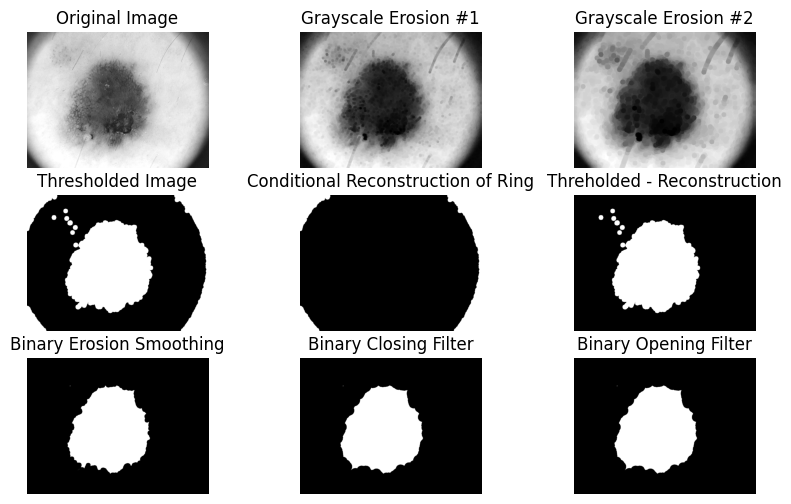

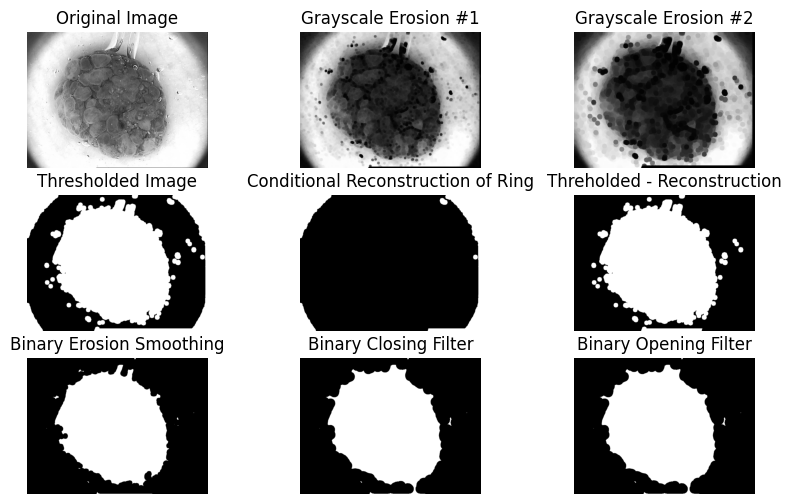

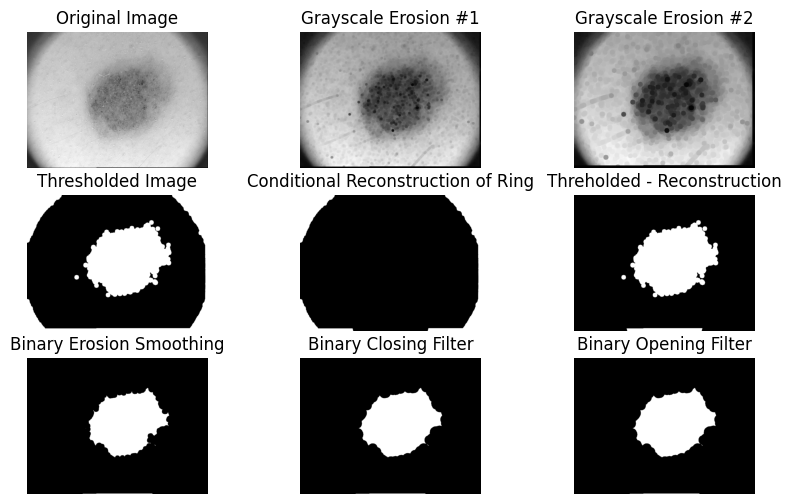

In [3]:
def generate_discrete_disk(radius):
    diameter = 2 * radius + 1 
    center = radius 

    # Generate a grid of coordinates
    x, y = np.meshgrid(np.arange(diameter), np.arange(diameter))

    # Calculate the distance from each point to the center
    distances = np.sqrt((x - center)**2 + (y - center)**2)

    # Create a mask for the disk
    disk_mask = (distances <= radius).astype(np.uint8)

    return disk_mask
def conditional_reconstruction(im, marker, b, num_iter = 10):
    for i in range(num_iter):
        temp = cv2.dilate(marker, b)
        marker = cv2.bitwise_and(im.astype(np.uint8), temp.astype(np.uint8))
    return marker
def plot_and_title(im, subplot_id, title):
    plt.subplot(subplot_id)
    plt.imshow(im, cmap = "gray")
    plt.title(title)
    plt.axis('off')  
def mask_segmentation(im, disp = False):
    # Initialize structural elements
    disk = generate_discrete_disk(5)
    big_disk = generate_discrete_disk(10)

    mask_steps = list()                             # List of intermediary steps, used for display purposes only
    mask = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)     # Initialize mask.
    mask_steps.append(mask)
    # Step 0: Gamma contrast enhance image
    mask = np.power(mask, 1.5).astype(np.uint16)
    # Step 1: Use repeated grayscale erosion to smooth out color variation
    mask = cv2.erode(mask, disk)
    mask_steps.append(mask)
    mask = cv2.erode(mask, disk)
    mask_steps.append(mask)

    # Step 2: Perform an initial thresholding operation in order to generate a binary approximation
    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)
    mask_steps.append(mask)

    # Step 3: Perform conditional reconstruction using the edge as a marker to get rid of ring edge artifact
    edge_marker = np.zeros(mask.shape)
    edge_marker[0, 0] = 1
    edge_marker[-1, 0] = 1
    edge_marker[0, -1] = 1
    edge_marker[-1,-1] = 1

    edge_marker[mask.shape[0]//2, 0] = 1
    edge_marker[mask.shape[0]//2, -1] = 1
    #edge_marker[0, mask.shape[1]//2] = 1
    #edge_marker[-1, mask.shape[1]//2] = 1
    recon = conditional_reconstruction(mask, edge_marker, big_disk, num_iter = 20)
    recon = conditional_reconstruction(mask, recon, disk, num_iter=5)
    mask_steps.append(recon) 

    # Step 4: Remove edge artifact by subtracting the conditional reconstruction from the original mask
    mask = mask == cv2.bitwise_not(recon.astype(np.uint8))
    mask_steps.append(mask)

    # Step 5: Smooth the binary mask with an erosion. This has the added benefit of reducing the size of
    #         segmented regions, making small artificial regions easy to filter out in the later steps
    mask = cv2.morphologyEx(mask.astype(np.uint16), cv2.MORPH_ERODE, big_disk)
    mask_steps.append(mask)
    
    # Step 6: Smooth the binary mask with a dilation to restore some of the original size
    # mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_DILATE, disk)
    # mask_steps.append(mask)

    # Step 7: Filter out small foreground shapes with a binary closing.
    mask = cv2.morphologyEx(mask.astype(np.uint16), cv2.MORPH_CLOSE,  generate_discrete_disk(20))
    mask_steps.append(mask)

    # Step 8: Now fill holes with a binary opening. Use a rectangular structural element. This acts like a bar
    #         to quickly flood background
    mask = cv2.morphologyEx(mask.astype(np.uint16), cv2.MORPH_CLOSE, np.ones([5, 70]))
    mask_steps.append(mask)
    # Plot each intermediary step
    if (disp == True):
        plt.figure(figsize=(10, 6)) 
        plot_and_title(mask_steps[0], 331, "Original Image")
        plot_and_title(mask_steps[1], 332, "Grayscale Erosion #1")
        plot_and_title(mask_steps[2], 333, "Grayscale Erosion #2")
        plot_and_title(mask_steps[3], 334, "Thresholded Image")
        plot_and_title(mask_steps[4], 335, "Conditional Reconstruction of Ring")
        plot_and_title(mask_steps[5], 336, "Threholded - Reconstruction")
        plot_and_title(mask_steps[6], 337, "Binary Erosion Smoothing")
        plot_and_title(mask_steps[7], 338, "Binary Closing Filter")
        plot_and_title(mask_steps[7], 339, "Binary Opening Filter")
    return mask

mask = mask_segmentation(images[121], disp = True)
mask = mask_segmentation(images[3], disp = True)
mask = mask_segmentation(images[72], disp = True)


In [4]:
## Now, evaluate IoU and DICE scores
def calc_dice(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    total = mask1.sum() + mask2.sum() 
    dice = 2 * intersection / total if total > 0 else 1
    return dice

def calc_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union if union > 0 else 1
    return iou

mask_hat = list()
iou = list()
dice = list()
temp_groundtruth = list()
for image_id in range(150):
    mask_hat.append(mask_segmentation(images[image_id], disp = False))
    ground_truth = cv2.cvtColor(masks[image_id], cv2.COLOR_BGR2GRAY) > 0
    temp_groundtruth.append(ground_truth)
    dice.append(calc_dice(mask_hat[image_id], ground_truth))  
    iou.append(calc_iou(mask_hat[image_id], ground_truth)) 

    # Print
    if image_id % 25 == 0:
        print("Working on image ", image_id)

Working on image  0
Working on image  25
Working on image  50
Working on image  75
Working on image  100
Working on image  125


0.7049051907715627 0.7521688620766359
0.8134062921313218 0.8585574289758326
0.8666666666666667 0.9666666666666667
0.8871243277443847
0.9401864145376517


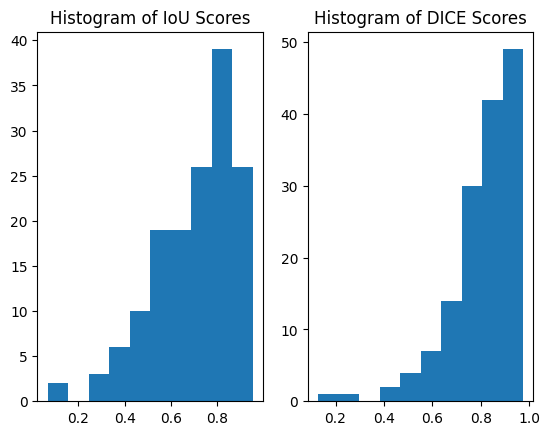

In [5]:
plt.figure()
plt.subplot(121)
plt.hist(iou)
plt.title("Histogram of IoU Scores")
plt.subplot(122)
plt.hist(dice)
plt.title("Histogram of DICE Scores")
print(np.mean(np.array(iou)), np.median(np.array(iou)))
print(np.mean(np.array(dice)), np.median(np.array(dice)))
print(np.sum(np.array(iou) > 0.5)/150, np.sum(np.array(dice) > 0.5)/150)
print(iou[121])
print(dice[121])

0.8716665077397413 0.7725255996732256
0.9401864145376517 0.8871243277443847


Text(0.5, 1.0, 'ground truth')

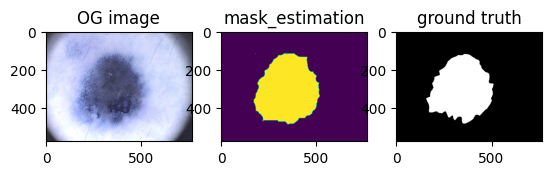

In [36]:
print(dice[4], iou[4])
print(dice[121], iou[121])
mask = mask_segmentation(images[121], disp = False)
plt.figure()
plt.subplot(131)
plt.imshow(images[121])
plt.title("OG image")

plt.subplot(132)
plt.imshow(mask)
plt.title("mask_estimation")

plt.subplot(133)
plt.imshow(masks[121])
plt.title("ground truth")

### Section 3 Symmetry Identification (with Math)

In [37]:
# center of the binary mask
def find_center(mask):
    # Mask Moments
    M = cv2.moments(mask)
    # Centroid coordinates
    if M["m00"] != 0:
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])
    else:
        center_x, center_y = 0, 0
    return center_x, center_y

# principal axis of the binary mask
def find_principal_axis(mask):
    # Find the nonzero pixel coordinates
    y, x = np.nonzero(np.array(mask))
    # Calculate the covariance matrix
    covariance_matrix = np.cov(x, y)
    # Compute the eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    # Sort the eigenvectors based on eigenvalues
    idx = eigenvalues.argsort()[::-1]
    eigenvectors = eigenvectors[:, idx]
    # Get the principal axis (eigenvector corresponding to the largest eigenvalue)
    principal_axis = eigenvectors[:, 0]
    return principal_axis

# Overlap when reflect over principal axis and its perpendicular axis
def find_overlap(mask):
    # Find the principal axis
    principal_axis = find_principal_axis(mask)
    # Find the perpendicular axis
    perpendicular_axis = np.array([-principal_axis[1], principal_axis[0]])
    # Reflect the mask across the principal axis
    reflected_mask_1 = cv2.flip(mask, 1)
    # Reflect the mask across the perpendicular axis
    reflected_mask_2 = cv2.flip(mask, 0)
    # Compute the overlap between the original mask and the two reflected masks
    overlap_1 = np.sum(np.logical_and(mask, reflected_mask_1)) / np.sum(mask)
    overlap_2 = np.sum(np.logical_and(mask, reflected_mask_2)) / np.sum(mask)

    return overlap_1, overlap_2


Text(0.5, 1.0, 'Symmetric Metrics Based on Ground Truth Masks')

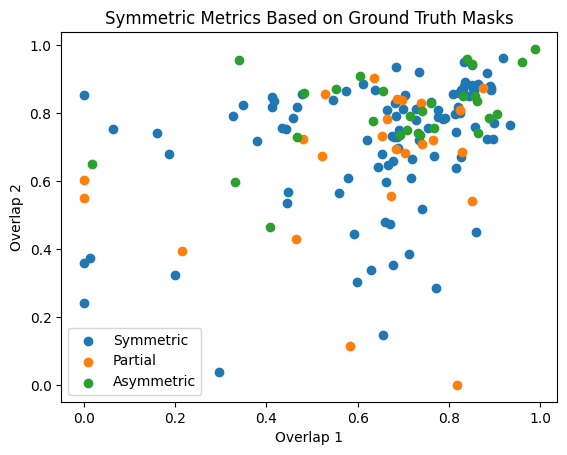

In [38]:
symmetry_data = list()

sym = list()
asym = list()
med = list()
for i in range(len(mask_hat)):
    mask = np.where(np.array(temp_groundtruth[i]), 1, 0)
    # center_x, center_y = find_center(mask)
    # principal_axis = find_principal_axis(mask)
    overlap_1, overlap_2 = find_overlap(mask)
    mask_info = {
                "gt_label": asymmetry_labels[i],
                "overlap_1": overlap_1,
                "overlap_2": overlap_2,
                }
    if (asymmetry_labels[i] == [1, 0, 0]): sym.append([overlap_1, overlap_2])
    elif (asymmetry_labels[i] == [0, 1, 0]): med.append([overlap_1, overlap_2])
    elif (asymmetry_labels[i] == [0, 0, 1]): asym.append([overlap_1, overlap_2])
    symmetry_data.append(mask_info)
sym = np.array(sym)
med = np.array(med)
asym = np.array(asym)
plt.scatter(sym[:, 0], sym[:, 1])
plt.scatter(med[:, 0], med[:, 1])
plt.scatter(asym[:, 0], asym[:, 1])
plt.legend(["Symmetric", "Partial", "Asymmetric"])
plt.xlabel("Overlap 1")
plt.ylabel("Overlap 2")
plt.title("Symmetric Metrics Based on Ground Truth Masks")

### Section 3: Symmetry Identification

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from torchsummary import summary

In [40]:
class SymmetryModel(nn.Module):
    def __init__(self, feature_input_size, num_classes, pretrained=True):
        super(SymmetryModel, self).__init__()

        # Load pre-trained backbone model
        backbone_model = models.resnet18(pretrained=pretrained)
        self.features_size = backbone_model.fc.in_features
        self.backbone = nn.Sequential(*list(backbone_model.children())[:-1])
        # Define additional layers for processing the combined input
        self.fc_layers = nn.Sequential(
            nn.Linear(self.features_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.Sigmoid()
        )
    def forward(self, image_input):
        # Pass image input through the backbone model
        image_features = self.backbone(image_input)
        image_features = torch.flatten(image_features, 1)

        # Pass combined input through FC layers
        output = self.fc_layers(image_features)

        return output
def train(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    loss_list = list()
    for epoch in range(epochs):
        running_loss = 0.0
        for mask, asymmetry in train_loader:
            mask, asymmetry = mask.to(device), asymmetry.to(device)
            optimizer.zero_grad()

            outputs = model(mask)

            loss = criterion(outputs.to(torch.float), asymmetry.to(torch.float))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss/len(train_loader))
        print("Epoch: ", str(epoch + 1), "/", str(epochs), ", Loss: " + str(running_loss/len(train_loader)))
    return model, loss_list
def acc_validation (prediction, actual_labels, thresh=0.9):
    acc_list = list()
    for batch in range(len(actual_labels)):
        for label in range(prediction[batch].shape[0]):
            pre = prediction[batch][label, :].detach().numpy()
            real = actual_labels[batch][label, :].detach().numpy()
            # Compute average similarity, and append
            pre = (pre == pre[np.argmax(pre)])
            acc_list.append(np.sum(pre == real) == 3)
    return acc_list
model = SymmetryModel(3, 3)

# Example usage of optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Change this according to your task

/Users/gabbykang/MIA/Medical-Image-Analysis-Spring-2024/MIA_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gabbykang/MIA/Medical-Image-Analysis-Spring-2024/MIA_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
batchsize = 32
image_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize the image to 300x300
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),           # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229])  # Normalize image
])

dataset = TensorDataset(torch.stack([image_transform(Image.fromarray(im.astype(np.uint8) * 255)) for im in mask_hat]), 
                # torch.stack([image_transform(Image.fromarray(im)) for im in images]), 
                torch.tensor(asymmetry_labels))
dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)




Iteration  0
Epoch:  1 / 5 , Loss: 1.094628381729126
Epoch:  2 / 5 , Loss: 1.0235843896865844
Epoch:  3 / 5 , Loss: 0.924643087387085
Epoch:  4 / 5 , Loss: 0.8388665199279786
Epoch:  5 / 5 , Loss: 0.7981353640556336
Correct predictions:  0.6533333333333333
Iteration  1
Epoch:  1 / 5 , Loss: 0.7940747380256653
Epoch:  2 / 5 , Loss: 0.7819012522697448
Epoch:  3 / 5 , Loss: 0.7724482655525208
Epoch:  4 / 5 , Loss: 0.7587064862251282
Epoch:  5 / 5 , Loss: 0.7660102248191833
Correct predictions:  0.7
Iteration  2
Epoch:  1 / 5 , Loss: 0.7555320620536804
Epoch:  2 / 5 , Loss: 0.7493831396102906
Epoch:  3 / 5 , Loss: 0.74034423828125
Epoch:  4 / 5 , Loss: 0.7476980328559876
Epoch:  5 / 5 , Loss: 0.7406998753547669
Correct predictions:  0.8133333333333334
Iteration  3
Epoch:  1 / 5 , Loss: 0.7223316192626953
Epoch:  2 / 5 , Loss: 0.7062829613685608
Epoch:  3 / 5 , Loss: 0.7107872605323792
Epoch:  4 / 5 , Loss: 0.7010705590248107
Epoch:  5 / 5 , Loss: 0.6872563838958741
Correct predictions:  0.

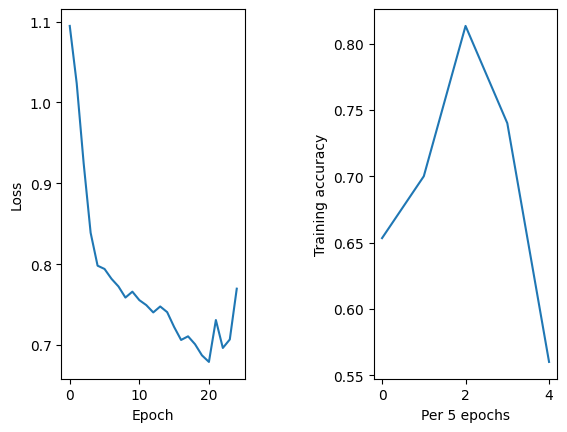

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
overall_loss = list()
val_acc = list()
# Train for 10 full iterations, each 10 epochs
for i in range(5):
    print("Iteration ", i)
    # Train the model
    [model, loss_list] = train(model, dataloader, optimizer, criterion, epochs=5)
    overall_loss.extend(loss_list)
    model.eval()
    prediction = list()
    actual_labels = list()
    # for mask, color, asymmetry, gt_labels in dataloader:
    #     prediction.append(model(mask, color, asymmetry))
    #     actual_labels.append(gt_labels)
    for mask, asymmetry in dataloader:
        prediction.append(model(mask))
        actual_labels.append(asymmetry)
    val_acc_entry = (acc_validation(prediction, actual_labels))
    torch.save(model.state_dict(), "asymmetry"+str(i)+".pth")
    print("Correct predictions: " , np.sum(np.array(val_acc_entry)) / 150)
    val_acc.append(np.sum(np.array(val_acc_entry)) / 150)
loss_arr = list()
for entry in overall_loss:
    loss_arr.append(entry)

np.save("symmetry_loss.npy", np.array(loss_arr))
np.save("symmetry_accuracy.npy", np.array(val_acc))
plt.subplot(1, 2, 1)
plt.plot(loss_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2,2)
plt.plot(val_acc)
plt.xlabel("Per 5 epochs")
plt.ylabel("Training accuracy")
plt.subplots_adjust(wspace=0.7, hspace=0.7)


In [70]:
np.sum(np.array(val_acc_entry)==3)

120

In [74]:
model = SymmetryModel(3, 3)
model.load_state_dict(torch.load("../asymmetryv1.pth"))
prediction = list()
actual_labels = list()
for mask, asymmetry in dataloader:
    prediction.append(model(mask))
    actual_labels.append(asymmetry)
val_acc_entry = (acc_validation(prediction, actual_labels))
print(np.sum(np.array(val_acc_entry)))

/Users/gabbykang/MIA/Medical-Image-Analysis-Spring-2024/MIA_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gabbykang/MIA/Medical-Image-Analysis-Spring-2024/MIA_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


386


### Section 4: Classification

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from torchsummary import summary

In [58]:
class NetworkModel(nn.Module):
    def __init__(self, feature_input_size, num_classes, pretrained=True):
        super(NetworkModel, self).__init__()

        # Load pre-trained backbone model
        backbone_model = models.resnet18(pretrained=pretrained)
        self.features_size = backbone_model.fc.in_features
        self.backbone = nn.Sequential(*list(backbone_model.children())[:-1])
        # Define additional layers for processing the combined input
        self.fc_layers = nn.Sequential(
            nn.Linear(self.features_size + feature_input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.Sigmoid()
        )

    def forward(self, image_input, feature_input):
        # Pass image input through the backbone model
        image_features = self.backbone(image_input)
        image_features = torch.flatten(image_features, 1)
        # olor_features = self.backbone(color_input)
        # color_features = torch.flatten(color_features, 1)
        # Concatenate image features with additional feature input
        combined_input = torch.cat((image_features, feature_input), dim=1)

        # Pass combined input through FC layers
        output = self.fc_layers(combined_input)

        
        return output


In [75]:
batchsize = 32
image_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize the image to 300x300
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),           # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229])  # Normalize image
])
dataset = TensorDataset(torch.stack([image_transform(Image.fromarray(im.astype(np.uint8) * 255)) for im in mask_hat]),
                torch.cat(prediction).detach(), torch.tensor(labels))
dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)


In [76]:
def train(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    loss_list = list()
    for epoch in range(epochs):
        running_loss = 0.0
        # for mask, color_images, asymmetry, labels in train_loader:
        #     mask, color_images, asymmetry, labels = mask.to(device), color_images.to(device), asymmetry.to(device), labels.to(device)
        for mask, asymmetry, labels in train_loader:
            mask, asymmetry, labels = mask.to(device), asymmetry.to(device), labels.to(device)
            optimizer.zero_grad()
        #     outputs = model(mask, color_images, asymmetry)
            outputs = model(mask, asymmetry)
            #print(outputs)
            loss = criterion(outputs.to(torch.float), labels.squeeze(1).to(torch.float))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss/len(train_loader))
        print("Epoch: ", str(epoch + 1), "/", str(epochs), ", Loss: " + str(running_loss/len(train_loader)))
    return model, loss_list

model = NetworkModel(3, 3)

# Example usage of optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Change this according to your task


In [61]:
def acc_validation (prediction, actual_labels, thresh=0.9):
    acc_list = list()
    for batch in range(len(actual_labels)):
        for label in range(prediction[batch].shape[0]):
            pre = prediction[batch][label, :].detach().numpy()
            real = actual_labels[batch][label, :].detach().numpy()
            # find the max value in the prediction:
            class_thresh = pre[np.argmax(pre)]
            # Convert predicted label into 1 hot encoded with class_thresh
            pre = pre >= class_thresh
            # Compute average similarity, and append
            acc_list.append(np.sum(pre == real))
    return acc_list

Iteration  0
Epoch:  1 / 10 , Loss: 0.7208545446395874
Epoch:  2 / 10 , Loss: 0.7180674552917481
Epoch:  3 / 10 , Loss: 0.7169814467430115
Epoch:  4 / 10 , Loss: 0.7182495355606079
Epoch:  5 / 10 , Loss: 0.7196021318435669
Epoch:  6 / 10 , Loss: 0.7295557379722595
Epoch:  7 / 10 , Loss: 0.7232172012329101
Epoch:  8 / 10 , Loss: 0.7243374705314636
Epoch:  9 / 10 , Loss: 0.733232045173645
Epoch:  10 / 10 , Loss: 0.7373549699783325
Correct predictions:  80
Iteration  1
Epoch:  1 / 10 , Loss: 0.7379800200462341
Epoch:  2 / 10 , Loss: 0.7245481610298157
Epoch:  3 / 10 , Loss: 0.7231100678443909
Epoch:  4 / 10 , Loss: 0.7209280252456665
Epoch:  5 / 10 , Loss: 0.7204068779945374
Epoch:  6 / 10 , Loss: 0.7179893255233765
Epoch:  7 / 10 , Loss: 0.7354845881462098
Epoch:  8 / 10 , Loss: 0.7267043709754943
Epoch:  9 / 10 , Loss: 0.7249096632003784
Epoch:  10 / 10 , Loss: 0.7257737874984741
Correct predictions:  79
Iteration  2
Epoch:  1 / 10 , Loss: 0.7232149720191956
Epoch:  2 / 10 , Loss: 0.744

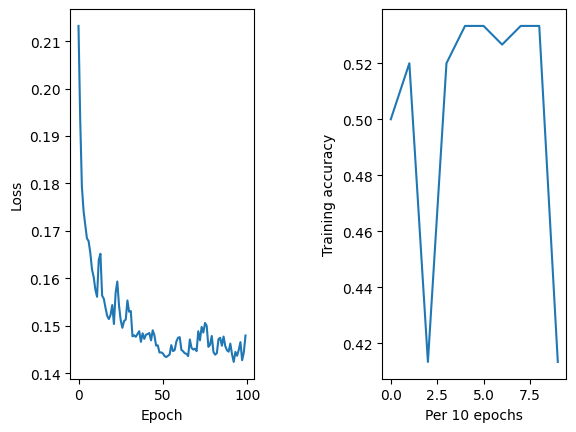

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# overall_loss = list()
# val_acc = list()
# Train for 10 full iterations, each 10 epochs
for i in range(5):
    print("Iteration ", i)
    # Train the model
    [model, loss_list] = train(model, dataloader, optimizer, criterion, epochs=10)
    overall_loss.extend(loss_list)
    model.eval()
    prediction = list()
    actual_labels = list()
    # for mask, color, asymmetry, gt_labels in dataloader:
    #     prediction.append(model(mask, color, asymmetry))
    #     actual_labels.append(gt_labels)
    for mask, asymmetry, gt_labels in dataloader:
        prediction.append(model(mask, asymmetry))
        actual_labels.append(gt_labels)
    val_acc_entry = (acc_validation(prediction, actual_labels, thresh=0.9))
    torch.save(model.state_dict(), "masks_and_asymmetrypartial"+str(i)+".pth")
    val_acc.append(val_acc_entry)
    print("Correct predictions: " , np.sum(np.array(val_acc_entry)== 3))
loss_arr = list()
for entry in overall_loss:
    loss_arr.append(entry/len(dataloader))
val_arr = list()
for entry in val_acc:
    val_arr.append(np.sum(np.array(entry) == 3)/150)
np.save("overall_loss.npy", np.array(loss_arr))
np.save("overall_accuracy.npy", np.array(val_arr))
plt.subplot(1, 2, 1)
plt.plot(loss_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2,2)
plt.plot(val_arr)
plt.xlabel("Per 10 epochs")
plt.ylabel("Training accuracy")
plt.subplots_adjust(wspace=0.7, hspace=0.7)

In [77]:
model.load_state_dict(torch.load("../masks_and_asymmetryv1.pth"))
prediction = list()
actual_labels = list()
for mask, asymmetry, gt_labels in dataloader:
    prediction.append(model(mask, asymmetry))
    actual_labels.append(gt_labels)
val_acc_entry = (acc_validation(prediction, actual_labels, thresh=0.9))

print("Correct predictions: " , np.sum(np.array(val_acc_entry)== 3))

Correct predictions:  150


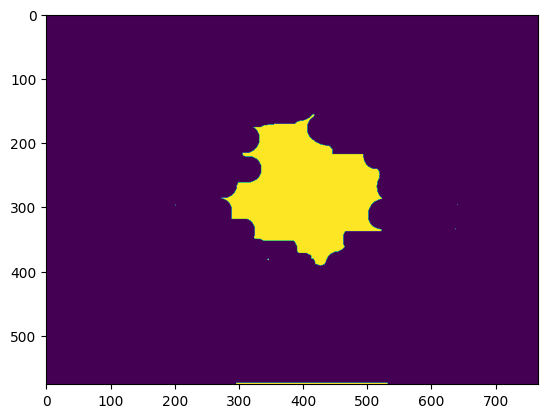

In [78]:
gt = cv2.imread("../test_dataset/Test01/test01_lesion.bmp", cv2.IMREAD_GRAYSCALE)
plt.imshow(gt)

